In [1]:
import cv2
import numpy as np
import random
import sys
from matplotlib import pyplot as plt
from skimage.measure import compare_ssim
import imutils

In [5]:
def showImg(img, title = str(round(random.random()*1000,0))):
    cv2.imshow(title, img)
    cv2.waitKey(0)
    cv2.destroyWindow(title)

In [3]:
def imageResizeByWidth(img, width=856):
    currRatio = img.shape[0]/img.shape[1]
    print('Shape: ', img.shape)
    height = int(width * currRatio)
    dim = (width, height)
    print('Resized shape: ', dim)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

In [6]:
fileNamePath = './data/tempEqualize2.jpg'
# fileNamePath = './data/temp2.jpg'

originImg = cv2.imread(fileNamePath)
showImg(originImg, "Origin image")

Getting Quoc Huy

In [7]:
qh_threshold = 10
minX = 70
minY = 50
qhDiameter = 180  # quoc huy co duong kinh la 14mm

qh = originImg[minY - qh_threshold:minY + qhDiameter + qh_threshold, minX -
               qh_threshold:minX + qhDiameter + qh_threshold]
# showImg(qh, "Quoc Huy")

Getting CMND number

In [ ]:
cardNu_threshold = 10
minX = 390
minY = 130
cardNuWidth = 360
cardNuHeight = 60

cardNu = originImg[minY - cardNu_threshold:minY + cardNuHeight + cardNu_threshold, minX -
               cardNu_threshold:minX + cardNuWidth + cardNu_threshold]
showImg(cardNu, "Card Number")

Loading Quoc Huy template

In [6]:
templateQh = cv2.imread('qhTemplate.png')
# templateQh = cv2.imread('qhTemplate.png', cv2.IMREAD_UNCHANGED)

templateQh = imageResizeByWidth(templateQh, 141)
templateQhGray = cv2.cvtColor(templateQh, cv2.COLOR_BGR2GRAY)
print("Shape: " ,templateQh.shape)
showImg(templateQh, 'Template QH')
# cv2.imwrite('qhTemplate.jpg', templateQh)

Shape:  (308, 303, 3)
Resized shape:  (141, 143)
Shape:  (143, 141, 3)


#### Quoc huy Shape

In [ ]:
qhShape = cv2.imread('quochuy2_shape.jpg',0)
# qhShape = imageResizeByWidth(qhShape, 140)
print("Shape: ", qhShape.shape)

# showImg(qhShape, 'edge QH')

In [ ]:

kernel = np.ones((1, 1), np.uint8)
qhShape = cv2.dilate(qhShape, kernel, iterations=1)
# showImg(qhShape, 'edge enhance QH')

qhShape = cv2.GaussianBlur(qhShape, (3, 3), cv2.BORDER_DEFAULT)
# showImg(qhShape, 'edge blur QH')


# Get edges
qhEdges = cv2.Canny(qhShape, 50, 120)
# showImg(qhEdges, 'edge QH')

In [ ]:
img = np.zeros(shape=[512, 1000, 3], dtype=np.uint8)

In [ ]:
contours, hierarchy = cv2.findContours(qhEdges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print ("Number of contours found = ", len(contours))

contours = sorted(contours, key=cv2.contourArea, reverse=True)

# img = qhShape.copy()
cv2.drawContours(img, contours, -1, (255,255,255), 2)

# for c in sorted_contours:
#     cv2.drawContours(orginal_image, [c], -1, (255,155,0), 3)
cv2.waitKey(0)
cv2.imshow('Contours by area', img)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
print(cv2.boundingRect(contours[0]))

temp = img[22:324+30,162:316+168]
temp = imageResizeByWidth(temp, 144)
temp = cv2.bitwise_not(temp)
showImg(temp)


In [ ]:
cv2.imwrite('qhShape.jpg', temp)

### Shape of QH

In [9]:
qhShape = cv2.imread('qhShape.jpg',0)
# kernel = np.ones((2, 2), np.uint8)
# qhShape = cv2.dilate(qhShape, kernel, iterations=1)
# showImg(qhShape, "shape")
ret, thresh1 = cv2.threshold(qhShape, 127, 255, 0)
# showImg(thresh1, "shape thresh")
contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
contours = sorted(contours, key=cv2.contourArea, reverse=True)

templateContour = contours[1]
# print(cv2.boundingRect(contours[0]))
# print(cv2.boundingRect(contours[1]))
# print(cv2.boundingRect(contours[2]))

qhShapeCopy = qhShape.copy()
cv2.drawContours(qhShapeCopy, [templateContour], -1, (0,255,234), 2)
showImg(qhShapeCopy,'res1')


3


## Get edge of origin qh

In [10]:
def getQHColor(img):
    # Convert BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#     showImg(hsv, "color")
    # cv.imshow("hsv", hsv)
    # define range of color in HSV

    ## Gen lower mask (0-5) and upper mask (175-180) of RED
    mask1 = cv2.inRange(hsv, (0,50,20), (35,255,255))
    mask2 = cv2.inRange(hsv, (170,50,20), (180,255,255))

    ## Merge the mask and crop the red regions
    mask = cv2.bitwise_or(mask1, mask2 )

    res = cv2.bitwise_and(img , img, mask= mask)
    res = cv2.cvtColor(res, cv2.COLOR_HSV2BGR)
    return res

In [11]:
def getEdgeImage(img):
    kernel = np.ones((1, 1), np.uint8)
    img = cv2.dilate(img, kernel, iterations=1)
#     showImg(img, 'edge enhance QH')
    img = cv2.GaussianBlur(img, (3,3), cv2.BORDER_DEFAULT)
    # showImg(img, 'edge blur QH')

    # Get edges
    edges = cv2.Canny(img, 50, 120)
    # showImg(qhEdges, 'edge QH')
    return edges

In [12]:
qhColorImg = getQHColor(qh)
showImg(qhColorImg, "qhColorImg")

qh_gray = cv2.cvtColor(qhColorImg, cv2.COLOR_BGR2GRAY)
originQhThresh = getEdgeImage(qh_gray)

# ret, originQhThresh = cv2.threshold(qh_gray, 127, 255, 0)
# showImg(originQhThresh, "originQhEdges")

# Extract contours from second target image
contours, hierarchy = cv2.findContours(originQhThresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
print("Length contours: ", len(contours))
maxContour = contours[0]
qhCopy = qh.copy()
cv2.drawContours(qhCopy, contours, -1, (0,255,0), 3)
showImg(qhCopy,'res')


Length contours:  1


### Create transparent image

In [ ]:
# Create an output of all zeroes that has the same shape as the input
# image
out = np.zeros_like(qh_gray)

# On this output, draw all of the contours that we have detected
# in white, and set the thickness to be 3 pixels
cv2.drawContours(out, contours, -1, 255, 3)
showImg(out, "qh pnd extract")

cv2.imwrite("qhExtract.png", out)

In [ ]:
img_height, img_width = qh.shape[:2]
n_channels = 4
alpha  = np.zeros((img_height, img_width, n_channels), dtype=np.uint8)
# alpha = np.ones(qh.shape) * 255 #creating a dummy alpha channel image.
# alpha = cv2.cvtColor(alpha, cv2.COLOR_BGR2BGRA)
print(alpha.shape)

b,g,r = cv2.split(qh)
out = cv2.cvtColor(qh, cv2.COLOR_RGB2RGBA)
print(out.shape)

# out[:, :, 3] = alpha
alpha_channel = np.ones(b.shape, dtype=b.dtype) * 255 #creating a dummy alpha channel image.
out = cv2.merge((b,g,r,alpha_channel))
print(out.shape)

showImg(out, "Merge qh")
# cv2.imwrite("qhExtract.png", out)

### Template matching contour

In [13]:
# Size of QH is 
closest_contour = []
minMatch = sys.maxsize
for c in contours:
    area = cv2.contourArea(c)
#     print("area: ", area)
    if area <= 10:  # skip ellipses smaller then 10x10
        continue
    # Iterate through each contour in the target image and 
    # use cv2.matchShapes to compare contour shapes
    match = cv2.matchShapes(templateContour, c, cv2.CONTOURS_MATCH_I1, 0.0)
#     print(match)
    if match < minMatch:
        closest_contour = c
        minMatch = match
#     print(match)
    # If the match value is less than 0.15 we
#     if match < 0.2:
#         closest_contour = c

# print(cv2.boundingRect(closest_contour))
# print("closest_contour: ", closest_contour)
if closest_contour != []:
    print("Min match: ", minMatch)
    qhCopy = qh.copy()
    cv2.drawContours(qhCopy, [closest_contour], -1, (50,155,30), 2)
    showImg(qhCopy, "Match template")
else:
    print("No match shape")

/home/hxtruong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Min match:  0.004071585901896713


8583627.0   56480312.0


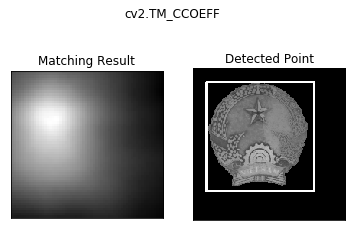

0.09093731641769409   0.6323011517524719


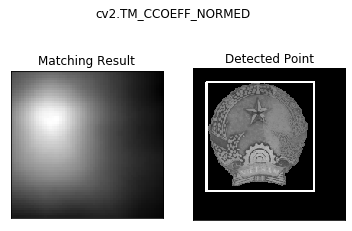

100000664.0   204751520.0


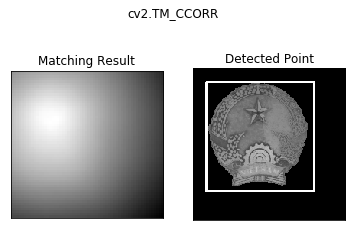

0.5251182317733765   0.8616712093353271


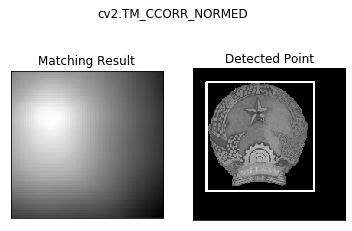

74862248.0   214463904.0


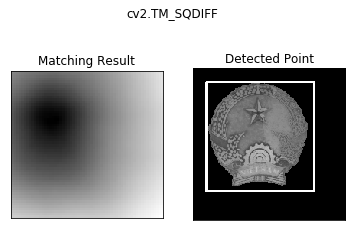

0.3150484263896942   1.0


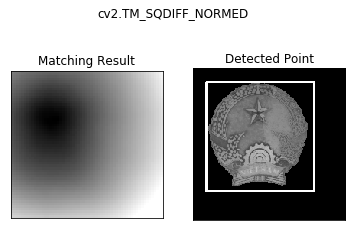

In [14]:

# img = cv2.imread('messi5.jpg',0)
img = qh_gray
img2 = img.copy()
# template = cv2.imread('template.jpg',0)
template = templateQhGray
w, h = template.shape[::-1]

# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for meth in methods:
    img = img2.copy()
    method = eval(meth)

    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
#     print(res)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    print(min_val, ' ', max_val)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(img,top_left, bottom_right, 255, 2)

    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    
    plt.savefig('matchingQHTemplate'+str(meth)+ '.png')

    plt.show()



Draw convex hull of qh

In [15]:
# create hull array for convex hull points
hull = []
 
# calculate points for each contour
for i in range(len(contours)):
    # creating convex hull object for each contour
    hull.append(cv2.convexHull(contours[i], False))

In [16]:
# create an empty black image
drawing = np.zeros((qh.shape[0], qh.shape[1], 3), np.uint8)
drawing = qh.copy()
# draw contours and hull points
# for i in range(len(contours)):
for i in range(0,1):
    color_contours = (0, 255, 0) # green - color for contours
    color = (255, 0, 0) # blue - color for convex hull
    # draw ith contour
#     cv2.drawContours(drawing, contours, i, color_contours, 1, 8, hierarchy)
    # draw ith convex hull object
    cv2.drawContours(drawing, hull, i, color, 1, 8)
showImg(drawing, "convex hull")

In [17]:
# calculate moments of binary image
M = cv2.moments(maxContour)
 
# calculate x,y coordinate of center
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
print(cX, cY)

84 86


In [18]:
rQh = 70
cropQh = qh[cY-rQh: cY+rQh+1, cX-rQh: cX+rQh+1]
print(cropQh.shape)
showImg(cropQh, "cropQh")

(141, 141, 3)


## Histogram of image

In [19]:
def drawHistorgram(img):
    # grab the image channels, initialize the tuple of colors,
    # the figure and the flattened feature vector
    chans = cv2.split(img)
    colors = ("b", "g", "r")
    plt.figure()
    plt.title("'Flattened' Color Histogram")
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    features = []

    # loop over the image channels
    for (chan, color) in zip(chans, colors):
        # create a histogram for the current channel and
        # concatenate the resulting histograms for each
        # channel
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        features.extend(hist)

        # plot the histogram
        plt.plot(hist, color = color)
        plt.xlim([0, 256])

    # here we are simply showing the dimensionality of the
    # flattened color histogram 256 bins for each channel
    # x 3 channels = 768 total values -- in practice, we would
    # normally not use 256 bins for each channel, a choice
    # between 32-96 bins are normally used, but this tends
    # to be application dependent
    print("flattened feature vector size: %d" % (np.array(features).flatten().shape))

flattened feature vector size: 768
(143, 141, 3)


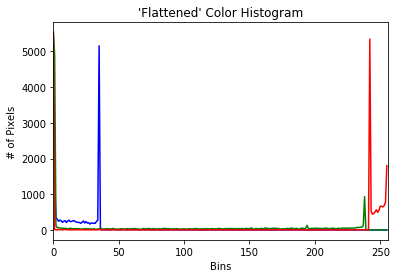

In [21]:
drawHistorgram(templateQh)
print(templateQh.shape)
showImg(templateQh, "Template qh")

flattened feature vector size: 768


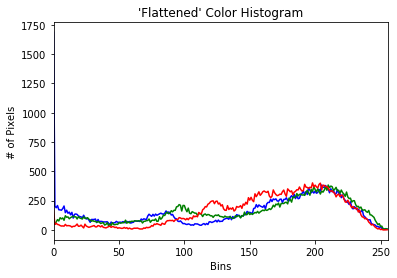

In [22]:
drawHistorgram(qh)

flattened feature vector size: 768


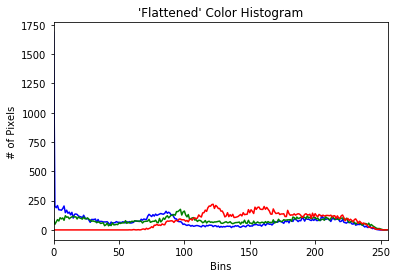

In [31]:
drawHistorgram(cropQh)

In [ ]:
img1 = cropQh
img1[cY-rQh: cY+rQh+1, cX-rQh: cX+rQh+1]

In [34]:
# cropQh = cv2.cvtColor(cropQh, cv2.COLOR_BGR2BGRA)
print(cropQh.shape)
print(templateQh.shape)

(141, 141, 3)
(143, 141, 3)


In [37]:
out = cv2.merge(cropQh, templateQh)
print(out.shape)
showImg(out, 'merge test')

error: OpenCV(4.1.0) /io/opencv/modules/core/src/merge.dispatch.cpp:129: error: (-215:Assertion failed) mv[i].size == mv[0].size && mv[i].depth() == depth in function 'merge'


In [54]:
# Set up the detector with default parameters.
detector = cv2.SimpleBlobDetector_create()

im = cv2.cvtColor(cropQh, cv2.COLOR_BGR2GRAY)
# im = cv2.imread("qhTemplate.png", cv2.IMREAD_GRAYSCALE)
showImg(im, 'im')
# Detect blobs.
print(im.shape)
keypoints = detector.detect(im)
print(keypoints)
# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
# im = cropQh.copy()
im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
showImg(im_with_keypoints, 'im_with_keypoints')

(141, 141)
[]


### Comare Blob

In [24]:
imageA = templateQh
imageB = cropQh
# convert the images to grayscale
grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
print(grayA.shape, grayB.shape)

(143, 141) (141, 141)


In [23]:
(score, diff) = compare_ssim(grayA, grayB, full=True)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(score))

ValueError: Input images must have the same dimensions.